### Preparation steps

Install iotfunctions with

`pip install git+https://github.com/ibm-watson-iot/functions@development`

This projects contains the code for the Analytics Service pipeline as well as the anomaly functions and should pull in most of this notebook's dependencies.

The plotting library matplotlib is the exception, so you need to run
`pip install matplotlib`


#### Install py4j
In addition install py4j v0.10.9.1-mm from my github clone
`git clone https://github.com/sedgewickmm18/py4j`

Install with
```
cd py4j-java
./gradlew clean assemble # build java jars
cd ..
pip install .  # install python and jars
```

#### Install timeseries-insights
Checkout WatFore forecasting library first

`git clone https://github.ibm.com/Common-TimeSeries-Analytics-Library/WatFore`

then timeseries-insights

`git clone https://github.ibm.com/Common-TimeSeries-Analytics-Library/timeseries-insights`

Finally apply a patch for allow for a callback server IP other than 127.0.0.1

`curl https://raw.githubusercontent.com/sedgewickmm18/tsi/master/context.py.patch | patch -p1`


Build WatFore
```
cd WatFore
mvn clean install -DskipTests
```

Build timeseries-insights
```
cd ../timeseries-insights
mvn clean install -DskipTests
```

Build the python distribution of tspy
```
cd python
python setup.py sdist
```

Install it

`pip install dist/tspy-2.0.5.0.tar.gz`


#### Run timeseries-insights as docker container

`docker run -p 25332:25332 -p 25333:25333 sedgewickmm18/tsi`

* port 25333 exposes the default port for the java server
* port 25332 allows for optional ssh based port forwarding (should not be necessary)

The patch above allows for callback server IP addresses other than 127.0.0.1, i.e. the python client that also acts as callback server for python lambda processing can listen to a docker bridge IP address. In my case I'm running it from my laptop on `172.17.0.1` while the container with the java process has IP address `172.17.0.2`.

##### Caveat:

The java process attempts to listen to IPv4 **and** IPv6 addresses so have to enable IPv6 for your docker bridge with

`sudo vi /etc/docker/daemon.json`

so that it looks similar to

```
{
    "insecure-registries" : ["localhost:32000"],
    "ipv6": true,
    "fixed-cidr-v6": "2001:db8:1::/64"
}
```

Then restart the docker daemon with

`systemctl restart docker`

and check with

`docker network inspect bridge`

In [1]:
# Real life data

import logging
import threading
import itertools
import pandas as pd  
import numpy as np  
import json
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.dbtables import FileModelStore
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from mmfunctions.anomaly import (SaliencybasedGeneralizedAnomalyScore, SpectralAnomalyScore,
                 FFTbasedGeneralizedAnomalyScore, KMeansAnomalyScore,
                 SaliencybasedGeneralizedAnomalyScorev2, FFTbasedGeneralizedAnomalyScorev2, 
                 KMeansAnomalyScorev2)                 
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)

/home/markus/.local/lib/python3.8/site-packages/iotfunctions/bif.py:1884: UserWarning: IoTCalcSettings is deprecated. Use entity type constants instead of a metadata provider to set entity type properties
  warnings.warn(('IoTCalcSettings is deprecated. Use entity type constants'


In [2]:
# setting to make life easier
Temperature='Vx'



In [3]:
# set up a db object with a FileModelStore to support scaling
with open('credentials_as_monitor_demo.json', encoding='utf-8') as F:
    credentials = json.loads(F.read())
db_schema=None
fm = FileModelStore()
db = Database(credentials=credentials, model_store=fm)
print (db)

2020-09-23T15:08:00.052 INFO iotfunctions.dbtables.__init__ Init FileModelStore


OperationalError: (ibm_db_dbi.OperationalError) ibm_db_dbi::OperationalError: Exception('[IBM][CLI Driver] SQL30081N  A communication error has been detected. Communication protocol being used: "TCP/IP".  Communication API being used: "SOCKETS".  Location where the error was detected: "169.48.206.167".  Communication function detecting the error: "connect".  Protocol specific error code(s): "113", "*", "*".  SQLSTATE=08001 SQLCODE=-30081')
(Background on this error at: http://sqlalche.me/e/e3q8)

In [4]:
# Run on the good pump first 
# Get stuff in
df_i = pd.read_csv('AllOfArmstark.csv', index_col=False, parse_dates=['timestamp'])

#df_i['entity']='MyRoom'
#df_i[Temperature]=df_i['value'] + 20
#df_i = df_i.drop(columns=['value'])

# and sort it by timestamp
df_i = df_i.sort_values(by='timestamp')
df_i = df_i.set_index(['entity','timestamp']).dropna()

df_i.head(2)

,,Vx,Vy,Vz,Ap,As,speed
entity,timestamp,,,,,,
04714B604101,2020-01-01 00:02:12.713,-0.0625,-0.0908,-1.0332,2.3650,1.036,1.042
04714B6046D5,2020-01-01 00:02:25.928,-0.0439,-0.0137,-1.0029,2.2904,1.036,1.036


In [5]:
# Simplify our pandas dataframe to prepare input for plotting
EngineLogging.configure_console_logging(logging.INFO)

df_inputm2 = df_i.loc[['04714B6046D5']]
df_inputm2.reset_index(level=[0], inplace=True)

# predicted just means normalized - need to modify the BaseEstimatorFunction superclass


In [6]:
# start the callback server

#from tspy import TSContext
import tspy
from tspy.data_structures.context import TSContext 
from py4j.java_gateway import JavaGateway, GatewayParameters, CallbackServerParameters


gateway = JavaGateway(gateway_parameters=GatewayParameters(address=u'172.17.0.2',
                                  auth_token='DZQv45+bq4TTHSF3FH2RoYqLoGjY2zMcojcQQpRFZMA='),
            callback_server_parameters=CallbackServerParameters(daemonize=True,port=25334,address=u'172.17.0.1',
                         auth_token='DZQv45+bq4TTHSF3FH2RoYqLoGjY2zMcojcQQpRFZMA=',daemonize_connections=True))



2020-09-23T15:08:08.044 INFO py4j.java_gateway.run Callback Server Starting
2020-09-23T15:08:08.045 INFO py4j.java_gateway.run Socket listening on ('172.17.0.1', 25334)


In [7]:
df_i

Vx      Vy      Vz      Ap     As  \
entity       timestamp                                                        
04714B604101 2020-01-01 00:02:12.713 -0.0625 -0.0908 -1.0332  2.3650  1.036   
04714B6046D5 2020-01-01 00:02:25.928 -0.0439 -0.0137 -1.0029  2.2904  1.036   
04714B604101 2020-01-01 00:03:12.713  0.0361  0.0078 -0.9141  2.3650  1.036   
04714B6046D5 2020-01-01 00:03:25.928 -0.0430 -0.0205 -0.9023  2.2904  1.036   
04714B604101 2020-01-01 00:04:12.713  0.1172 -0.0332 -0.9756  2.3650  1.036   
...                                      ...     ...     ...     ...    ...   
             2020-01-31 12:10:16.047 -0.0088 -0.0361 -0.9160  2.2800  1.032   
04714B6046D5 2020-01-31 12:10:23.501 -0.0879 -0.0322 -0.8750  2.2760  1.037   
             2020-01-31 12:11:23.501  0.0596 -0.0166 -0.9795  2.2744  1.037   
             2020-01-31 12:12:23.501  0.0801 -0.0215 -1.0166  2.2744  1.037   
             2020-01-31 12:13:23.501 -0.0957  0.0029 -0.9854  2.2744  1.037   

                                      speed  
entity       timestamp                       
04714B604101 2020-01-01 00:02:12.713  1.042  
04714B6046D5 2020-01-01 00:02:25.928  1.036  
04714B604101 2020-01-01 00:03:12.713  1.042  
04714B6046D5 2020-01-01 00:03:25.928  1.036  
04714B604101 2020-01-01 00:04:12.713  1.042  
...                                     ...  
             2020-01-31 12:10:16.047  1.033  
04714B6046D5 2020-01-31 12:10:23.501  1.037  
             2020-01-31 12:11:23.501  1.037  
             2020-01-31 12:12:23.501  1.037  
             2020-01-31 12:13:23.501  1.037  

[258495 rows x 6 columns]

In [8]:
import datetime

df = df_i.reset_index()[['entity','timestamp','Vx']] #['entity'=='04714B6046D5']
df = df[df['entity']=='04714B6046D5']


tsc = TSContext(gateway=gateway, jvm=gateway.jvm, daemonize=True)

model = tspy.forecasters.arima(500)

model_map = {
        '04714B6046D5': model,
}

In [9]:
df

,entity,timestamp,Vx
1,04714B6046D5,2020-01-01 00:02:25.928,-0.0439
3,04714B6046D5,2020-01-01 00:03:25.928,-0.0430
5,04714B6046D5,2020-01-01 00:04:25.928,0.0039
7,04714B6046D5,2020-01-01 00:05:25.928,0.0283
9,04714B6046D5,2020-01-01 00:06:25.928,-0.0771
...,...,...,...
258489,04714B6046D5,2020-01-31 12:09:23.501,0.0293
258491,04714B6046D5,2020-01-31 12:10:23.501,-0.0879
258492,04714B6046D5,2020-01-31 12:11:23.501,0.0596
258493,04714B6046D5,2020-01-31 12:12:23.501,0.0801


In [10]:
dfs = df.tail(20000)
mts_raw = tsc.multi_time_series\
        .df_observations(dfs, dfs.keys()[0], dfs.keys()[1], dfs.keys()[2], granularity=datetime.timedelta(milliseconds=1))\
        .with_trs(granularity=datetime.timedelta(minutes=1)) \
        .transform(tsc.duplicate_transforms.combine_duplicate_time_ticks(lambda x: float(sum(x) / len(x))))

In [11]:
dfss = mts_raw.to_df()

2020-09-23T15:08:22.879 INFO py4j.java_gateway.run Callback Connection ready to receive messages
2020-09-23T15:08:22.880 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:22.890 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:22.892 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:22.895 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:22.898 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:22.899 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:22.901 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:22.902 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:22.904 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:22.905 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:22.906 INFO py4j.java_gate

2020-09-23T15:08:23.039 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.040 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.042 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.043 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.044 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.045 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.047 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.053 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.056 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.058 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.059 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.061 INFO py4j.java_gateway.run Rec

2020-09-23T15:08:23.202 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.203 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.205 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.206 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.208 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.209 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.211 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.212 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.213 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.215 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.217 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.218 INFO py4j.java_gateway.run Rec

2020-09-23T15:08:23.328 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.329 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.330 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.331 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.332 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.333 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.334 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.335 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.336 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.337 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.338 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.339 INFO py4j.java_gateway.run Rec

2020-09-23T15:08:23.463 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.464 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.466 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.467 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.469 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.470 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.471 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.472 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.474 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.475 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.476 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.477 INFO py4j.java_gateway.run Rec

2020-09-23T15:08:23.593 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.595 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.596 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.597 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.599 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.600 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.602 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.605 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.606 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.608 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.609 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.610 INFO py4j.java_gateway.run Rec

2020-09-23T15:08:23.713 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.714 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.715 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.716 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.717 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.718 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.719 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.720 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.720 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.721 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.722 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.723 INFO py4j.java_gateway.run Rec

2020-09-23T15:08:23.820 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.821 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.823 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.825 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.826 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.828 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.829 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.830 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.832 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.834 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.835 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.837 INFO py4j.java_gateway.run Rec

2020-09-23T15:08:23.954 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.955 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.956 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.957 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.958 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.959 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.960 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.961 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.962 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.963 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.965 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:23.967 INFO py4j.java_gateway.run Rec

2020-09-23T15:08:24.062 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.063 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.064 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.064 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.065 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.066 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.067 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.068 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.069 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.070 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.071 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.071 INFO py4j.java_gateway.run Rec

2020-09-23T15:08:24.161 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.162 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.163 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.164 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.165 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.167 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.168 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.170 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.171 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.172 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.173 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.175 INFO py4j.java_gateway.run Rec

2020-09-23T15:08:24.281 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.283 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.284 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.286 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.287 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.288 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.289 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.290 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.291 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.292 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.293 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.294 INFO py4j.java_gateway.run Rec

2020-09-23T15:08:24.393 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.394 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.395 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.396 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.397 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.398 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.399 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.400 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.401 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.403 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.404 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.405 INFO py4j.java_gateway.run Rec

2020-09-23T15:08:24.492 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.493 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.494 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.495 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.495 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.496 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.500 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.501 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.502 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.503 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.504 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.505 INFO py4j.java_gateway.run Rec

2020-09-23T15:08:24.593 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.594 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.595 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.596 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.597 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.598 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.599 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.600 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.601 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.602 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.603 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.604 INFO py4j.java_gateway.run Rec

2020-09-23T15:08:24.683 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.683 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.684 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.685 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.686 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.687 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.687 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.688 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.689 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.690 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.691 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.691 INFO py4j.java_gateway.run Rec

2020-09-23T15:08:24.772 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.773 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.774 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.775 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.776 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.777 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.778 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.779 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.780 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.781 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.781 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.783 INFO py4j.java_gateway.run Rec

2020-09-23T15:08:24.867 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.868 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.869 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.869 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.870 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.871 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.872 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.872 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.873 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.874 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.875 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.875 INFO py4j.java_gateway.run Rec

2020-09-23T15:08:24.962 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.963 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.964 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.965 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.965 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.966 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.968 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.969 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.969 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.970 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.971 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:24.972 INFO py4j.java_gateway.run Rec

2020-09-23T15:08:25.055 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.056 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.057 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.058 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.059 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.059 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.060 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.061 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.062 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.063 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.063 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.064 INFO py4j.java_gateway.run Rec

2020-09-23T15:08:25.156 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.157 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.158 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.159 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.160 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.161 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.162 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.162 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.163 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.164 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.165 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.166 INFO py4j.java_gateway.run Rec

2020-09-23T15:08:25.249 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.250 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.251 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.252 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.253 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.254 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.255 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.256 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.260 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.261 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.262 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.263 INFO py4j.java_gateway.run Rec

2020-09-23T15:08:25.368 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.369 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.370 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.371 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.372 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.373 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.374 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.375 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.377 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.378 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.379 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.380 INFO py4j.java_gateway.run Rec

2020-09-23T15:08:25.480 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.481 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.482 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.484 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.485 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.486 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.488 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.490 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.491 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.493 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.498 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.499 INFO py4j.java_gateway.run Rec

2020-09-23T15:08:25.585 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.585 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.586 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.587 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.588 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.589 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.589 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.590 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.591 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.592 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.592 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.593 INFO py4j.java_gateway.run Rec

2020-09-23T15:08:25.670 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.671 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.672 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.673 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.674 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.675 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.677 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.678 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.679 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.680 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.681 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.681 INFO py4j.java_gateway.run Rec

2020-09-23T15:08:25.753 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.754 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.755 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.759 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.760 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.761 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.762 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.763 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.764 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.765 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.766 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.767 INFO py4j.java_gateway.run Rec

2020-09-23T15:08:25.845 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.846 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.847 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.848 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.849 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.850 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.851 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.852 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.853 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.853 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.855 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.856 INFO py4j.java_gateway.run Rec

2020-09-23T15:08:25.936 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.937 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.938 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.939 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.939 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.940 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.941 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.942 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.943 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.944 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.945 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:25.946 INFO py4j.java_gateway.run Rec

2020-09-23T15:08:26.031 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.032 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.033 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.034 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.035 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.036 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.036 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.037 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.038 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.039 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.040 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.040 INFO py4j.java_gateway.run Rec

2020-09-23T15:08:26.118 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.118 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.119 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.120 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.120 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.121 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.122 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.123 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.124 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.124 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.125 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.126 INFO py4j.java_gateway.run Rec

2020-09-23T15:08:26.202 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.203 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.204 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.204 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.207 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.208 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.209 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.210 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.211 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.211 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.212 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.213 INFO py4j.java_gateway.run Rec

2020-09-23T15:08:26.287 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.288 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.288 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.289 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.290 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.290 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.292 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.292 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.293 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.294 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.294 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.296 INFO py4j.java_gateway.run Rec

2020-09-23T15:08:26.382 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.383 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.384 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.385 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.386 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.387 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.388 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.388 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.390 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.391 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.391 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.392 INFO py4j.java_gateway.run Rec

2020-09-23T15:08:26.478 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.478 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.480 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.481 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.482 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.483 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.484 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.485 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.486 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.486 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.487 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.489 INFO py4j.java_gateway.run Rec

2020-09-23T15:08:26.586 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.587 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.588 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.589 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.589 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.590 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.591 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.592 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.594 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.595 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.596 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.597 INFO py4j.java_gateway.run Rec

2020-09-23T15:08:26.667 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.667 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.668 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.669 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.669 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.670 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.671 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.671 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.672 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.673 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.674 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.677 INFO py4j.java_gateway.run Rec

2020-09-23T15:08:26.753 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.754 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.755 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.756 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.757 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.758 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.759 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.760 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.761 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.762 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.764 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.765 INFO py4j.java_gateway.run Rec

2020-09-23T15:08:26.845 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.846 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.847 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.847 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.848 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.849 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.849 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.850 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.851 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.852 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.852 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.853 INFO py4j.java_gateway.run Rec

2020-09-23T15:08:26.926 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.927 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.928 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.929 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.930 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.930 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.931 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.932 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.933 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.933 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.934 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:26.935 INFO py4j.java_gateway.run Rec

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2020-09-23T15:08:27.617 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:27.618 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:27.619 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:27.620 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:27.621 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:27.622 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:27.623 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:27.624 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:27.625 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:27.625 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:27.628 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:27.629 INFO py4j.java_gateway.run Rec

2020-09-23T15:08:27.710 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:27.711 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:27.712 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:27.713 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:27.714 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:27.715 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:27.716 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:27.717 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:27.718 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:27.719 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:27.720 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:27.721 INFO py4j.java_gateway.run Rec

2020-09-23T15:08:27.811 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:27.812 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:27.813 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:27.814 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:27.815 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:27.816 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:27.817 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:27.818 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:27.819 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:27.820 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:27.821 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:27.822 INFO py4j.java_gateway.run Rec

2020-09-23T15:08:27.901 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:27.902 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:27.902 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:27.903 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:27.904 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:27.905 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:27.905 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:27.906 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:27.907 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:27.908 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:27.908 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:27.909 INFO py4j.java_gateway.run Rec

2020-09-23T15:08:27.996 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:27.997 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:27.998 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:27.999 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.000 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.002 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.003 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.004 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.005 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.009 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.010 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.011 INFO py4j.java_gateway.run Rec

2020-09-23T15:08:28.101 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.102 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.103 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.104 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.105 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.106 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.107 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.107 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.108 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.109 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.110 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.111 INFO py4j.java_gateway.run Rec

2020-09-23T15:08:28.193 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.194 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.195 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.196 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.197 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.198 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.201 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.202 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.203 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.204 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.205 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.206 INFO py4j.java_gateway.run Rec

2020-09-23T15:08:28.290 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.291 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.292 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.293 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.294 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.295 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.296 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.297 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.297 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.298 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.299 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.300 INFO py4j.java_gateway.run Rec

2020-09-23T15:08:28.382 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.383 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.384 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.385 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.386 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.387 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.388 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.389 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.390 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.391 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.392 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.392 INFO py4j.java_gateway.run Rec

2020-09-23T15:08:28.476 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.477 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.478 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.479 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.479 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.480 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.481 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.482 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.483 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.484 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.485 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.486 INFO py4j.java_gateway.run Rec

2020-09-23T15:08:28.580 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.581 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.583 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.585 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.586 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.588 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.589 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.591 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.592 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.593 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.595 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.596 INFO py4j.java_gateway.run Rec

2020-09-23T15:08:28.696 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.697 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.698 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.698 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.699 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.700 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.701 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.702 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.703 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.704 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.704 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.705 INFO py4j.java_gateway.run Rec

2020-09-23T15:08:28.781 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.782 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.783 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.783 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.784 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.785 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.786 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.786 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.787 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.788 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.789 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.790 INFO py4j.java_gateway.run Rec

2020-09-23T15:08:28.863 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.864 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.865 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.866 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.867 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.868 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.868 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.869 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.870 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.871 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.872 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.873 INFO py4j.java_gateway.run Rec

2020-09-23T15:08:28.955 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.956 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.957 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.958 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.959 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.960 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.960 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.961 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.962 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.963 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.964 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:28.967 INFO py4j.java_gateway.run Rec

2020-09-23T15:08:29.046 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.047 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.047 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.048 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.049 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.050 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.051 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.051 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.052 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.053 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.054 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.054 INFO py4j.java_gateway.run Rec

2020-09-23T15:08:29.133 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.134 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.136 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.137 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.137 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.138 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.139 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.140 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.141 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.145 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.146 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.146 INFO py4j.java_gateway.run Rec

2020-09-23T15:08:29.214 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.215 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.216 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.216 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.217 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.218 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.218 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.219 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.220 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.220 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.221 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.222 INFO py4j.java_gateway.run Rec

2020-09-23T15:08:29.295 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.297 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.298 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.299 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.300 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.301 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.302 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.302 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.303 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.304 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.305 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.306 INFO py4j.java_gateway.run Rec

2020-09-23T15:08:29.377 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.378 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.379 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.379 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.380 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.381 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.382 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.383 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.383 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.384 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.387 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.387 INFO py4j.java_gateway.run Rec

2020-09-23T15:08:29.459 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.459 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.460 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.461 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.461 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.462 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.463 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.463 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.464 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.465 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.466 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.466 INFO py4j.java_gateway.run Rec

2020-09-23T15:08:29.537 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.537 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.538 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.539 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.541 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.542 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.543 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.543 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.544 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.545 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.546 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.546 INFO py4j.java_gateway.run Rec

2020-09-23T15:08:29.634 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.635 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.636 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.637 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.638 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.638 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.640 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.640 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.641 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.642 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.642 INFO py4j.java_gateway.run Received command c on object id p0
2020-09-23T15:08:29.643 INFO py4j.java_gateway.run Rec

In [12]:
dfss

,timestamp,key,value
0,26334532,04714B6046D5,-0.020500
1,26334533,04714B6046D5,-0.009067
2,26334534,04714B6046D5,0.026700
3,26334535,04714B6046D5,0.069300
4,26334536,04714B6046D5,0.015300
...,...,...,...
6677,26341209,04714B6046D5,0.029300
6678,26341210,04714B6046D5,-0.087900
6679,26341211,04714B6046D5,0.059600
6680,26341212,04714B6046D5,0.080100


In [13]:
model.update_model(dfss['timestamp'].astype(int).tolist(), dfss['value'].tolist())
#model.update_model(mts_raw)

In [14]:
model

Forecasting Model
  Algorithm: RegularARIMAAlgorithm [armaAlgorithm=RegularARMAAlgorithm [dataHistory=WeightedHistory [weights=[-0.20176167052768776, -0.5883934830656194], history=com.ibm.watson.pm.util.CircularBuffer@c2a4c920, historyLength=2, dataCount=6682], errorHistory=WeightedHistory [weights=null, history=null, historyLength=0, dataCount=0], dataMean=0.008636178861788515, minTrainingData=80, pMin=0, pMax=5, qMin=0, qMax=5, forceModel=false], differencer=null, minTrainingData=82, diffOrder=-1]

In [15]:
forecasts = mts_raw.forecast(100, model_map, confidence=0.97)

In [16]:
df2 = mts_raw.to_df()

In [17]:
df2.describe()

,timestamp,value
count,6.682000e+03,6682.000000
mean,2.633787e+07,0.007490
std,1.929072e+03,0.026912
min,2.633453e+07,-0.129233
25%,2.633620e+07,-0.010067
50%,2.633787e+07,0.007800
75%,2.633954e+07,0.024400
max,2.634121e+07,0.151367


In [18]:
for k, series in forecasts.items():
    for k2 in series:
        print(k2)
        print(k2.value)
        ser = pd.Series
        df2 = df2.append({'timestamp': k2.time_tick, 'key': k, 'value': k2.value['value']}, ignore_index=True)

2020-09-23T15:09:07.388 INFO py4j.java_gateway.run Received command c on object id p101
2020-09-23T15:09:07.390 INFO py4j.java_gateway.run Callback Connection ready to receive messages
2020-09-23T15:09:07.391 INFO py4j.java_gateway.run Received command c on object id p1
TimeStamp: 26341214     Value: {value=-0.012361626027272043, lower_bound=-0.06894428353943802, upper_bound=0.044221031484893925, error=0.02607387143524321}
2020-09-23T15:09:07.392 INFO py4j.java_gateway.run Received command c on object id p1
{value=-0.012361626027272043, lower_bound=-0.06894428353943802, upper_bound=0.044221031484893925, error=0.02607387143524321}
2020-09-23T15:09:07.393 INFO py4j.java_gateway.run Received command c on object id p1
2020-09-23T15:09:07.398 INFO py4j.java_gateway.run Received command c on object id p102
2020-09-23T15:09:07.399 INFO py4j.java_gateway.run Received command c on object id p2
TimeStamp: 26341215     Value: {value=0.07426345874386522, lower_bound=0.016315441143630767, upper_bou

2020-09-23T15:09:07.489 INFO py4j.java_gateway.run Received command c on object id p114
2020-09-23T15:09:07.489 INFO py4j.java_gateway.run Received command c on object id p14
TimeStamp: 26341227     Value: {value=0.008916502081850356, lower_bound=-0.04908985798539367, upper_bound=0.06692286214909438, error=0.026729928238074553}
2020-09-23T15:09:07.490 INFO py4j.java_gateway.run Received command c on object id p14
{value=0.008916502081850356, lower_bound=-0.04908985798539367, upper_bound=0.06692286214909438, error=0.026729928238074553}
2020-09-23T15:09:07.491 INFO py4j.java_gateway.run Received command c on object id p14
2020-09-23T15:09:07.495 INFO py4j.java_gateway.run Received command c on object id p115
2020-09-23T15:09:07.496 INFO py4j.java_gateway.run Received command c on object id p15
TimeStamp: 26341228     Value: {value=0.006534406915676166, lower_bound=-0.051476179480886466, upper_bound=0.0645449933122388, error=0.026731875774159662}
2020-09-23T15:09:07.497 INFO py4j.java_gat

2020-09-23T15:09:07.579 INFO py4j.java_gateway.run Received command c on object id p27
TimeStamp: 26341240     Value: {value=0.008639791994079278, lower_bound=-0.049410828273346315, upper_bound=0.06669041226150488, error=0.026750323794239163}
2020-09-23T15:09:07.580 INFO py4j.java_gateway.run Received command c on object id p27
{value=0.008639791994079278, lower_bound=-0.049410828273346315, upper_bound=0.06669041226150488, error=0.026750323794239163}
2020-09-23T15:09:07.580 INFO py4j.java_gateway.run Received command c on object id p27
2020-09-23T15:09:07.584 INFO py4j.java_gateway.run Received command c on object id p128
2020-09-23T15:09:07.585 INFO py4j.java_gateway.run Received command c on object id p28
TimeStamp: 26341241     Value: {value=0.00870210523513361, lower_bound=-0.04935247333772264, upper_bound=0.06675668380798987, error=0.026752147822155813}
2020-09-23T15:09:07.586 INFO py4j.java_gateway.run Received command c on object id p28
{value=0.00870210523513361, lower_bound=-0

TimeStamp: 26341253     Value: {value=0.00863566720869493, lower_bound=-0.04936167929226491, upper_bound=0.06663301370965477, error=0.026725774693882744}
2020-09-23T15:09:07.659 INFO py4j.java_gateway.run Received command c on object id p40
{value=0.00863566720869493, lower_bound=-0.04936167929226491, upper_bound=0.06663301370965477, error=0.026725774693882744}
2020-09-23T15:09:07.660 INFO py4j.java_gateway.run Received command c on object id p40
2020-09-23T15:09:07.665 INFO py4j.java_gateway.run Received command c on object id p141
2020-09-23T15:09:07.665 INFO py4j.java_gateway.run Received command c on object id p41
TimeStamp: 26341254     Value: {value=0.00863415475391532, lower_bound=-0.04936647878217729, upper_bound=0.06663478829000793, error=0.02672728939353142}
2020-09-23T15:09:07.666 INFO py4j.java_gateway.run Received command c on object id p41
{value=0.00863415475391532, lower_bound=-0.04936647878217729, upper_bound=0.06663478829000793, error=0.02672728939353142}
2020-09-23T1

{value=0.008636207436751336, lower_bound=-0.049342494961307284, upper_bound=0.06661490983480996, error=0.026717183299214377}
2020-09-23T15:09:07.742 INFO py4j.java_gateway.run Received command c on object id p53
2020-09-23T15:09:07.805 INFO py4j.java_gateway.run Received command c on object id p154
2020-09-23T15:09:07.806 INFO py4j.java_gateway.run Received command c on object id p54
TimeStamp: 26341267     Value: {value=0.008636239592060281, lower_bound=-0.04934655963222196, upper_bound=0.06661903881634253, error=0.026719071158939317}
2020-09-23T15:09:07.807 INFO py4j.java_gateway.run Received command c on object id p54
{value=0.008636239592060281, lower_bound=-0.04934655963222196, upper_bound=0.06661903881634253, error=0.026719071158939317}
2020-09-23T15:09:07.808 INFO py4j.java_gateway.run Received command c on object id p54
2020-09-23T15:09:07.812 INFO py4j.java_gateway.run Received command c on object id p155
2020-09-23T15:09:07.812 INFO py4j.java_gateway.run Received command c on

2020-09-23T15:09:07.888 INFO py4j.java_gateway.run Received command c on object id p167
2020-09-23T15:09:07.888 INFO py4j.java_gateway.run Received command c on object id p67
TimeStamp: 26341280     Value: {value=0.008636177086363852, lower_bound=-0.0493691778126087, upper_bound=0.0666415319853364, error=0.026729465046180897}
2020-09-23T15:09:07.889 INFO py4j.java_gateway.run Received command c on object id p67
{value=0.008636177086363852, lower_bound=-0.0493691778126087, upper_bound=0.0666415319853364, error=0.026729465046180897}
2020-09-23T15:09:07.889 INFO py4j.java_gateway.run Received command c on object id p67
2020-09-23T15:09:07.893 INFO py4j.java_gateway.run Received command c on object id p168
2020-09-23T15:09:07.894 INFO py4j.java_gateway.run Received command c on object id p68
TimeStamp: 26341281     Value: {value=0.008636179974272878, lower_bound=-0.049373362100194024, upper_bound=0.06664572204873978, error=0.02673139453978047}
2020-09-23T15:09:07.895 INFO py4j.java_gateway

2020-09-23T15:09:07.966 INFO py4j.java_gateway.run Received command c on object id p80
TimeStamp: 26341293     Value: {value=0.00863617891211564, lower_bound=-0.04931183530539649, upper_bound=0.06658419312962777, error=0.02670304186950195}
2020-09-23T15:09:07.966 INFO py4j.java_gateway.run Received command c on object id p80
{value=0.00863617891211564, lower_bound=-0.04931183530539649, upper_bound=0.06658419312962777, error=0.02670304186950195}
2020-09-23T15:09:07.967 INFO py4j.java_gateway.run Received command c on object id p80
2020-09-23T15:09:07.971 INFO py4j.java_gateway.run Received command c on object id p181
2020-09-23T15:09:07.972 INFO py4j.java_gateway.run Received command c on object id p81
TimeStamp: 26341294     Value: {value=0.008636178821147929, lower_bound=-0.04927867937238252, upper_bound=0.06655103701467838, error=0.02668776323211352}
2020-09-23T15:09:07.972 INFO py4j.java_gateway.run Received command c on object id p81
{value=0.008636178821147929, lower_bound=-0.0492

TimeStamp: 26341306     Value: {value=0.008636178860416672, lower_bound=-0.04927509748773246, upper_bound=0.06654745520856581, error=0.02668611268086549}
2020-09-23T15:09:08.043 INFO py4j.java_gateway.run Received command c on object id p93
{value=0.008636178860416672, lower_bound=-0.04927509748773246, upper_bound=0.06654745520856581, error=0.02668611268086549}
2020-09-23T15:09:08.044 INFO py4j.java_gateway.run Received command c on object id p93
2020-09-23T15:09:08.048 INFO py4j.java_gateway.run Received command c on object id p194
2020-09-23T15:09:08.048 INFO py4j.java_gateway.run Received command c on object id p94
TimeStamp: 26341307     Value: {value=0.008636178863221967, lower_bound=-0.049277986875438023, upper_bound=0.06655034460188196, error=0.026687444141776286}
2020-09-23T15:09:08.049 INFO py4j.java_gateway.run Received command c on object id p94
{value=0.008636178863221967, lower_bound=-0.049277986875438023, upper_bound=0.06655034460188196, error=0.026687444141776286}
2020-0

Text(0, 0.5, 'Pump Vibration')

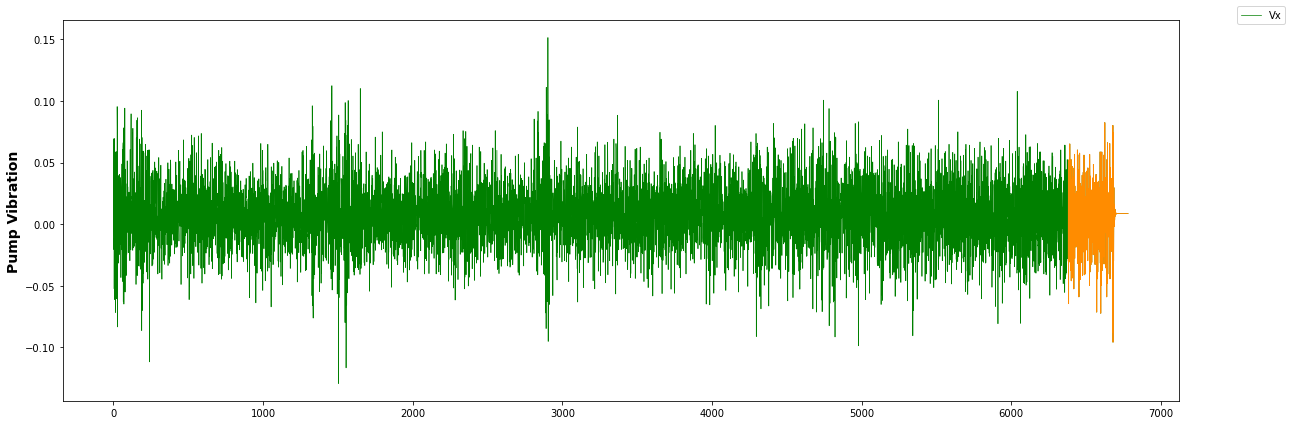

2020-09-23T15:09:44.025 INFO py4j.java_gateway.run Received command  on object id 
2020-09-23T15:09:44.027 INFO py4j.java_gateway.run Received command  on object id 
2020-09-23T15:09:44.027 INFO py4j.java_gateway.close Closing down callback connection
2020-09-23T15:09:44.029 INFO py4j.java_gateway.close Closing down callback connection
2020-09-23T15:13:17.122 INFO py4j.java_gateway.run Callback Connection ready to receive messages
2020-09-23T15:13:17.125 INFO py4j.java_gateway.run Received command g on object id p102
2020-09-23T15:13:17.127 INFO py4j.java_gateway.run Received command g on object id p101
2020-09-23T15:13:17.130 INFO py4j.java_gateway.run Received command g on object id p154
2020-09-23T15:13:17.132 INFO py4j.java_gateway.run Received command g on object id p152
2020-09-23T15:13:17.136 INFO py4j.java_gateway.run Received command g on object id p151
2020-09-23T15:13:17.139 INFO py4j.java_gateway.run Received command g on object id p150
2020-09-23T15:13:17.141 INFO py4j.jav

2020-09-23T15:13:17.233 INFO py4j.java_gateway.run Received command g on object id p163
2020-09-23T15:13:17.235 INFO py4j.java_gateway.run Received command g on object id p162
2020-09-23T15:13:17.236 INFO py4j.java_gateway.run Received command g on object id p161
2020-09-23T15:13:17.237 INFO py4j.java_gateway.run Received command g on object id p160
2020-09-23T15:13:17.237 INFO py4j.java_gateway.run Received command g on object id p159
2020-09-23T15:13:17.239 INFO py4j.java_gateway.run Received command g on object id p158
2020-09-23T15:13:17.240 INFO py4j.java_gateway.run Received command g on object id p157
2020-09-23T15:13:17.241 INFO py4j.java_gateway.run Received command g on object id p156
2020-09-23T15:13:17.243 INFO py4j.java_gateway.run Received command g on object id p155
2020-09-23T15:14:14.025 INFO py4j.java_gateway.run Received command  on object id 
2020-09-23T15:14:14.027 INFO py4j.java_gateway.close Closing down callback connection


In [20]:
dftail = df2.tail(400)
fig, ax = plt.subplots(1, 1, figsize=(20,7))
ax.plot(df2.index, df2['value'],linewidth=0.7,color='green',label=Temperature)
ax.plot(dftail.index, dftail['value'],linewidth=0.9,color='darkorange')
ax.legend(bbox_to_anchor=(1.1, 1.05))
ax.set_ylabel('Pump Vibration',fontsize=14,weight="bold")

#### nothing of interest below ... ;-)

just a lot of really old stuff 

In [146]:
# df_inputm2[spectral].values[df_inputm2[spectral] > 0.001] = 0.001
# df_inputm2[fft].values[df_inputm2[fft] < -1] = -1
df_inputm2[kmeansA] = df_inputm2[kmeans]
df_inputm2[kmeansA].values[df_inputm2[kmeansA] < kmeans_break] = np.nan
df_inputm2[kmeansA].values[df_inputm2[kmeansA] > kmeans_break] = kmeans_break
df_inputm2[kmeansB] = df_inputm2[kmeans]
df_inputm2[kmeansB].values[df_inputm2[kmeansB] >= kmeans_break] = 4
df_inputm2[kmeansB].values[df_inputm2[kmeansB] < kmeans_break] = 3

# Scale spectral and saliency 
# df_inputm2[spectral].values[df_inputm2[spectral] >= spectral_break] = -spectral_break
# df_inputm2[sal].values[df_inputm2[sal] > sal_break] = sal_break



df_inputm2[fftA] = df_inputm2[fft]
df_inputm2[fftA].values[df_inputm2[fftA] < fft_break] = np.nan
df_inputm2[fftA].values[df_inputm2[fftA] > fft_break] = fft_break
df_inputm2[spectralA] = df_inputm2[spectral]
df_inputm2[spectralA].values[df_inputm2[spectralA] < spectral_break] = np.nan
df_inputm2[spectralA].values[df_inputm2[spectralA] > spectral_break] = spectral_break
df_inputm2[salA] = df_inputm2[sal]
df_inputm2[salA].values[df_inputm2[salA] < sal_break] = np.nan
df_inputm2[salA].values[df_inputm2[salA] > sal_break] = sal_break
#df_inputm2[genA] = df_inputm2[gen]
#df_inputm2[genA].values[df_inputm2[genA] < gen_break] = np.nan
#df_inputm2[genA].values[df_inputm2[genA] > gen_break] = gen_break

plots = 5

fig, ax = plt.subplots(plots, 1, figsize=(16,24))
cnt = 0
ax[cnt].plot(df_inputm2.index, df_inputm2[Temperature]-20,linewidth=1,color='black',label=Temperature)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('Input Temperature - 20',fontsize=14,weight="bold")
cnt = 1
#ax[cnt].plot(df_inputm2.index, df_inputm2[Temperature]-20,linewidth=1,color='black',label=Input)
#ax[cnt].plot(df_inputm2.index, df_inputm2[kmeans], linewidth=2, color='magenta',label=kmeans)
#ax[cnt].plot(df_inputm2.index, df_inputm2[fft]/fft_break, linewidth=2,color='darkgreen',label=fft)
#ax[cnt].plot(df_inputm2.index, -df_inputm2[spectral]/spectral_break, linewidth=2,color='dodgerblue', label=spectral)
#ax[cnt].plot(df_inputm2.index, df_inputm2[sal]/sal_break, linewidth=2,color='chartreuse',label=sal)
#ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
#ax[cnt].set_ylabel('ALL',fontsize=14,weight="bold")
cnt = 1
ax[cnt].plot(df_inputm2.index, df_inputm2[Temperature]-20,linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_inputm2.index, df_inputm2[kmeans], linewidth=2, color='magenta',label=kmeans)
ax[cnt].plot(df_inputm2.index, df_inputm2[kmeansA], linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('KMeans \n detects chanages in "steepness"',fontsize=13)
cnt = 2
ax[cnt].plot(df_inputm2.index, df_inputm2[Temperature]-20,linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_inputm2.index, df_inputm2[fft]/fft_break, linewidth=2,color='darkgreen',label=fft)
ax[cnt].plot(df_inputm2.index, df_inputm2[fftA]/fft_break, linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('FFT \n detects frequency changes', fontsize=13)
cnt = 3
ax[cnt].plot(df_inputm2.index, df_inputm2[Temperature]-20,linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_inputm2.index, df_inputm2[spectral]/spectral_break, linewidth=2,color='dodgerblue', label=spectral)
ax[cnt].plot(df_inputm2.index, df_inputm2[spectralA]/spectral_break, linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('Spectral \n like FFT for less "CPU"\n less sensitive', fontsize=13)
cnt = 4
ax[cnt].plot(df_inputm2.index, df_inputm2[Temperature]-20,linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_inputm2.index, df_inputm2[sal]/sal_break, linewidth=2,color='chartreuse', label=sal)
ax[cnt].plot(df_inputm2.index, df_inputm2[salA]/sal_break, linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('Saliency \n like FFT, part of Azure\'s approach', fontsize=13)

for i in range(plots):
    ax[i].grid(True, color='white')
    ax[i].set_facecolor('lightgrey')

<ipython-input-146-9a44dc620b2f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputm2[kmeansA] = df_inputm2[kmeans]


NameError: name 'kmeansB' is not defined

In [62]:
# any detected anomaly segment should overlap with a real anomaly segment (true positive)
# any detected anomaly segment should overlap with only one 'real' anomaly segment 
#   (otherwise it's a hidden false positive)
# any real anomaly must overlap with a detected anomaly (false negative)

anomalyList_ = [('2017-10-09 23:07:00','2017-10-09 23:23:00'),
                ('2017-10-10 13:35:00','2017-10-10 13:36:00'),
                ('2017-10-10 13:38:00','2017-10-10 13:40:00'),
                ('2017-10-10 16:19:00','2017-10-10 16:27:00'),
                ('2017-10-11 00:10:00','2017-10-11 00:17:00'),
                ('2017-10-11 18:11:00','2017-10-11 18:17:00'),
                ('2017-10-12 00:05:00','2017-10-12 00:23:00'),
                ('2017-10-12 08:09:00','2017-10-12 08:12:00'),
                ('2017-10-12 10:34:00','2017-10-12 10:41:00'),
                ('2017-10-12 14:04:00','2017-10-12 14:11:00'),
                ('2017-10-12 16:22:00','2017-10-12 16:28:00'),
                ('2017-10-12 18:52:00','2017-10-12 18:58:00'),
                ('2017-10-12 19:51:00','2017-10-12 19:58:00')]
anomalyList = []

for a in anomalyList_:
    anomalyList.append((pd.Timestamp(a[0]),pd.Timestamp(a[1])))


def get_anom_list(df, label):
    anomList = np.split(df[label], np.where(np.isnan(df[label].values))[0])
    anomList = [a[~np.isnan(a)] for a in anomList] 
    anomList = [a[~np.isnan(a)] for a in anomList] 
    anomList = [a for a in anomList if not a.empty]
    anomList2 = []
    for a in anomList:
        anomList2.append((a.first('1T').index[0], a.last('1T').index[0]))
    return anomList2

def overlapping_segment(a, b):
    x = max(a[0], b[0])
    y = min(a[1], b[1])
    return x<y

def charact(anomList):
    TP = 0
    FP = 0
    FN = 0

    for i in anomalyList:
        found = False
        for j in anomFFT:
            if overlapping_segment(i,j):
                TP += 1
                found = True
                break
        if not found:
            FN += 1

    for j in anomFFT:
        found = False
        for i in anomalyList:
            if overlapping_segment(i,j):
                found = True
                break
        if not found:
            print(j)
            FP += 1
            
    return TP, FP, FN

    
# split along NaN
anomFFT = get_anom_list(df_inputm2, fftA)

TP, FP, FN = charact(anomFFT)

print ('TP ', TP, ' FP ', FP, ' FN ', FN)

anomKM = get_anom_list(df_inputm2, kmeansA)

TP, FP, FN = charact(anomKM)

print ('TP ', TP, ' FP ', FP, ' FN ', FN)





(Timestamp('2017-10-12 18:16:00'), Timestamp('2017-10-12 18:37:00'))
TP  13  FP  1  FN  0
(Timestamp('2017-10-12 18:16:00'), Timestamp('2017-10-12 18:37:00'))
TP  13  FP  1  FN  0


#### Results

Clear **winners** are 
* **KMeans** and 
* **FFT**.

Spectral is way too sensitive while Saliency 
doesn't detect the negative peak at 10/10 midnight


In [64]:
# need a helper function to convert array columns to something easier
from scipy import linalg
def l2norm(df, tcol, col1, col2 = None, col3 = None):
    l2vib = []
    for index, row in df.iterrows():
        l2vib_element = linalg.norm(np.fromstring(row[col1].replace('[',' ').replace(']',''), sep = ','))**2
        if col2 is not None:
            l2vib_element = l2vib_element + \
                            linalg.norm(np.fromstring(row[col2].replace('[',' ').replace(']',''), sep = ','))**2
        if col3 is not None:
            l2vib_element = l2vib_element + \
                            linalg.norm(np.fromstring(row[col3].replace('[',' ').replace(']',''), sep = ','))**2
        l2vib.append(l2vib_element**(1/2))
    df[tcol] = np.asarray(l2vib)
    

def unrollAccel(df):
    l0,l1,l2,l3,l4=[],[],[],[],[]
    for i in df['ACCEL_POWER'].values:
        l0.append(eval(eval(i)[0]))
        l1.append(eval(eval(i)[1]))
        l2.append(eval(eval(i)[2]))
        l3.append(eval(eval(i)[3]))
        l4.append(eval(eval(i)[4]))
    df['accel_power_0'] = np.asarray(l0)
    df['accel_power_1'] = np.asarray(l1)
    df['accel_power_2'] = np.asarray(l2)
    df['accel_power_3'] = np.asarray(l3)
    df['accel_power_4'] = np.asarray(l4)
    
listAttr = ['timestamp','entity','vibrations','rms','accel_speed','accel_power_0','accel_power_1',
            'accel_power_2','accel_power_3','accel_power_4']

In [65]:
# Now we proceed to customer data - GOOD CASE

# Get stuff in
df_input_raw = pd.read_csv('./Armstark04714B6046D5.csv', index_col=False, parse_dates=['RCV_TIMESTAMP_UTC'])
df_input_raw['entity']=df_input_raw['DEVICE_ID']
df_input_raw['timestamp']=df_input_raw['RCV_TIMESTAMP_UTC']

# and sort it by timestamp
df_input_raw = df_input_raw.sort_values(by='timestamp')
df_input_raw = df_input_raw.set_index(['entity','timestamp']).dropna()

l2norm(df_input_raw, 'vibrations', 'VIBRATIONS_XAXIS', 'VIBRATIONS_YAXIS', 'VIBRATIONS_ZAXIS')
l2norm(df_input_raw, 'rms', 'RMS_X', 'RMS_Y', 'RMS_Z')
l2norm(df_input_raw, 'accel_speed', 'ACCEL_SPEED')
unrollAccel(df_input_raw)
#l2norm(df_input_raw, 'accel_power', 'ACCEL_POWER')

df_input = df_input_raw.filter(listAttr, axis=1)
df_input_raw.describe()

<ipython-input-64-80608205ccaa>:6: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  l2vib_element = linalg.norm(np.fromstring(row[col1].replace('[',' ').replace(']',''), sep = ','))**2
<ipython-input-64-80608205ccaa>:9: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  linalg.norm(np.fromstring(row[col2].replace('[',' ').replace(']',''), sep = ','))**2
<ipython-input-64-80608205ccaa>:12: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  linalg.norm(np.fromstring(row[col3].replace('[',' ').replace(']',''), sep = ','))**2


,vibrations,rms,accel_speed,accel_power_0,accel_power_1,accel_power_2,accel_power_3,accel_power_4
count,8620.000000,8.620000e+03,8620.0,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000
mean,3.759047,1.732051e+00,1.0,2.453523,2.453312,2.452808,2.452053,2.452439
std,0.033272,4.441150e-16,0.0,0.856247,0.857594,0.857678,0.857200,0.856340
min,3.616515,1.732051e+00,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.737696,1.732051e+00,1.0,2.251800,2.251800,2.252000,2.252000,2.251800
50%,3.757949,1.732051e+00,1.0,2.313800,2.313400,2.311800,2.312200,2.312600
75%,3.780154,1.732051e+00,1.0,2.691450,2.692100,2.685100,2.681850,2.682300
max,3.898555,1.732051e+00,1.0,5.325799,5.293200,5.334001,5.278600,5.282000


In [66]:
# Run Monitoring's anomaly detector functions

salii = SaliencybasedGeneralizedAnomalyScore('vibrations', 12, 'SaliencyVibrationScore')
et = salii._build_entity_type(columns = [Column('vibrations',Float())])
salii._entity_type = et
df_input = salii.execute(df=df_input)


spsii = SpectralAnomalyScore('vibrations', 12, 'SpectralVibrationScore')
et = spsii._build_entity_type(columns = [Column('vibrations',Float())])
spsii._entity_type = et
df_input = spsii.execute(df=df_input)

kmii = KMeansAnomalyScore('vibrations', 12, 'KMeansVibrationScore')
et = kmii._build_entity_type(columns = [Column('vibrations',Float())])
kmii._entity_type = et
df_input = kmii.execute(df=df_input)

fftii = FFTbasedGeneralizedAnomalyScore('vibrations', 12, 'FFTVibrationScore')
et = fftii._build_entity_type(columns = [Column('vibrations',Float())])
fftii._entity_type = et
df_input = fftii.execute(df=df_input)

df_input.describe()

2020-06-02T14:07:50.781 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-06-02T14:07:50.782 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-06-02T14:07:52.442 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-06-02T14:07:52.443 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-06-02T14:07:52.760 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-06-02T14:07:52.761 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.


/home/markus/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


2020-06-02T14:07:57.854 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-06-02T14:07:57.854 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.


,vibrations,rms,accel_speed,accel_power_0,accel_power_1,accel_power_2,accel_power_3,accel_power_4,SaliencyVibrationScore,SpectralVibrationScore,KMeansVibrationScore,FFTVibrationScore
count,8620.000000,8.620000e+03,8620.0,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000
mean,3.759047,1.732051e+00,1.0,2.453523,2.453312,2.452808,2.452053,2.452439,17.785380,25.259561,0.087914,13.626316
std,0.033272,4.441150e-16,0.0,0.856247,0.857594,0.857678,0.857200,0.856340,14.486994,25.227880,0.025500,7.899369
min,3.616515,1.732051e+00,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.356699,0.005063,0.022573,0.771379
25%,3.737696,1.732051e+00,1.0,2.251800,2.251800,2.252000,2.252000,2.251800,5.833554,10.339797,0.071338,8.418707
50%,3.757949,1.732051e+00,1.0,2.313800,2.313400,2.311800,2.312200,2.312600,14.630254,20.552395,0.085002,12.017826
75%,3.780154,1.732051e+00,1.0,2.691450,2.692100,2.685100,2.681850,2.682300,26.112277,32.141765,0.101584,17.253135
max,3.898555,1.732051e+00,1.0,5.325799,5.293200,5.334001,5.278600,5.282000,98.672447,302.745841,0.217574,63.261967


In [67]:
EngineLogging.configure_console_logging(logging.INFO)

df_input2 = df_input.loc[['04714B6046D5']]
df_input2.reset_index(level=[0], inplace=True)

# redefine
# setting to make life easier
Temperature='vibrations'
kmeans='KMeansVibrationScore'
fft='FFTVibrationScore'
spectral='SpectralVibrationScore'
sal='SaliencyVibrationScore'
#gen='TemperatureGeneralizedScore'
kmeansA='kmeansAnomaly'
kmeansB='kmeansAnomalyB'
spectralA='spectralAnomaly'
fftA='fftAnomaly'
salA='salAnomaly'
genA='genAnomaly'

kmeans_break=1.3
spectral_break = 2.8
fft_break = 100
sal_break = 100
gen_break = 30000

df_input2

,entity,vibrations,rms,accel_speed,accel_power_0,accel_power_1,accel_power_2,accel_power_3,accel_power_4,SaliencyVibrationScore,SpectralVibrationScore,KMeansVibrationScore,FFTVibrationScore
timestamp,,,,,,,,,,,,,
2020-01-01 00:02:25.928,04714B6046D5,3.787826,1.732051,1.0,2.2904,2.2824,2.2858,2.2956,2.3278,9.955894,34.626486,0.107194,6.657871
2020-01-01 00:07:26.074,04714B6046D5,3.776503,1.732051,1.0,2.2822,2.2978,2.2966,2.3504,2.3190,9.036381,32.208784,0.100376,6.755634
2020-01-01 00:12:25.663,04714B6046D5,3.715573,1.732051,1.0,2.2718,2.2908,2.2912,2.3044,2.3232,8.116868,29.791082,0.093557,6.853397
2020-01-01 00:17:26.020,04714B6046D5,3.765538,1.732051,1.0,2.2748,2.2932,2.2926,2.3146,2.3606,7.197354,27.373380,0.086738,6.951160
2020-01-01 00:22:25.727,04714B6046D5,3.725934,1.732051,1.0,2.3320,2.2980,2.2998,2.3212,2.2860,6.277841,24.955677,0.079920,7.048923
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-31 11:39:23.476,04714B6046D5,3.725156,1.732051,1.0,2.2778,2.2798,2.2676,2.2718,2.2668,7.662554,8.877056,0.100228,16.899648
2020-01-31 11:44:23.497,04714B6046D5,3.766786,1.732051,1.0,2.2734,2.2704,2.2694,2.2728,2.2670,7.307044,7.748011,0.087977,15.013700
2020-01-31 11:49:23.443,04714B6046D5,3.737750,1.732051,1.0,2.2666,2.2714,2.2712,2.2690,2.2646,6.951534,6.618966,0.075727,13.127752


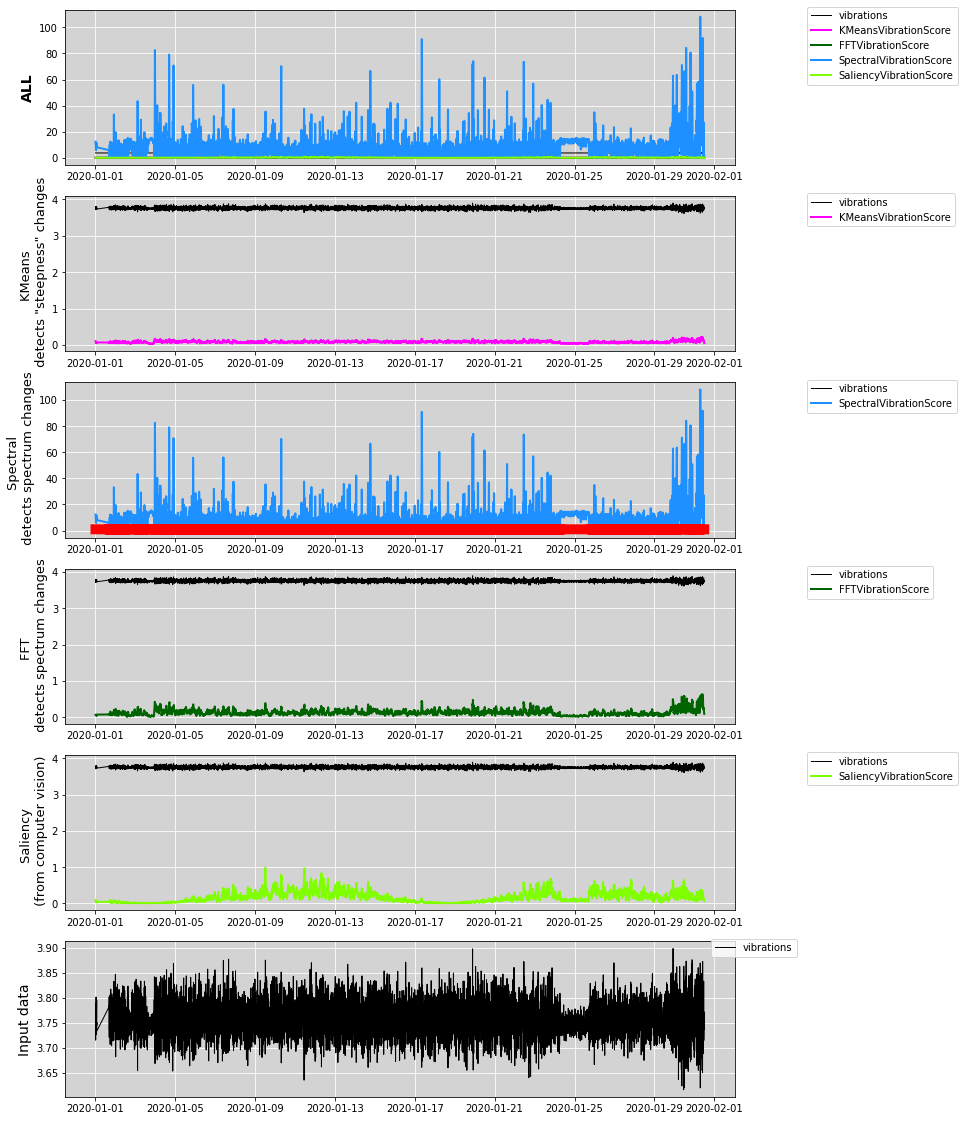

In [68]:
# df_input2[spectral].values[df_input2[spectral] > 0.001] = 0.001
df_input2[fft].values[df_input2[fft] < -1] = -1
df_input2[kmeansA] = df_input2[kmeans]
df_input2[kmeansA].values[df_input2[kmeansA] < kmeans_break] = np.nan
df_input2[kmeansA].values[df_input2[kmeansA] > kmeans_break] = kmeans_break
df_input2[kmeansB] = df_input2[kmeans]
df_input2[kmeansB].values[df_input2[kmeansB] >= kmeans_break] = 4
df_input2[kmeansB].values[df_input2[kmeansB] < kmeans_break] = 3



df_input2[fftA] = df_input2[fft]
df_input2[fftA].values[df_input2[fftA] < fft_break] = np.nan
df_input2[fftA].values[df_input2[fftA] > fft_break] = fft_break
df_input2[spectralA] = df_input2[spectral]
df_input2[spectralA].values[df_input2[spectralA] < spectral_break] = np.nan
df_input2[spectralA].values[df_input2[spectralA] > spectral_break] = spectral_break
df_input2[salA] = df_input2[sal]
df_input2[salA].values[df_input2[salA] < sal_break] = np.nan
df_input2[salA].values[df_input2[salA] > sal_break] = sal_break
#df_input2[genA] = df_input2[gen]
#df_input2[genA].values[df_input2[genA] < gen_break] = np.nan
#df_input2[genA].values[df_input2[genA] > gen_break] = gen_break

plots = 6

fig, ax = plt.subplots(plots, 1, figsize=(12,20))
cnt = 0
ax[cnt].plot(df_input2.index, df_input2[Temperature],linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_input2.index, df_input2[kmeans], linewidth=2, color='magenta',label=kmeans)
ax[cnt].plot(df_input2.index, df_input2[fft]/fft_break, linewidth=2,color='darkgreen',label=fft)
ax[cnt].plot(df_input2.index, df_input2[spectral]/spectral_break, linewidth=2,color='dodgerblue', label=spectral)
ax[cnt].plot(df_input2.index, df_input2[sal]/sal_break, linewidth=2,color='chartreuse',label=sal)
#ax[0].plot(df_input2.index, df_input2[gen]/gen_break, linewidth=2,color='darkviolet',label=gen)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('ALL',fontsize=14,weight="bold")
cnt=1
ax[cnt].plot(df_input2.index, df_input2[Temperature],linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_input2.index, df_input2[kmeans], linewidth=2, color='magenta',label=kmeans)
#ax[cnt].plot(df_input2.index, df_input2[kmeansB], linewidth=2, color='yellow') #label=kmeans)
ax[cnt].plot(df_input2.index, df_input2[kmeansA], linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('KMeans \n detects "steepness" changes',fontsize=13)
cnt=2
ax[cnt].plot(df_input2.index, df_input2[Temperature],linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_input2.index, df_input2[spectral]/spectral_break, linewidth=2,color='dodgerblue', label=spectral)
ax[cnt].plot(df_input2.index, df_input2[spectralA]/spectral_break, linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('Spectral \n detects spectrum changes', fontsize=13)
cnt=3
ax[cnt].plot(df_input2.index, df_input2[Temperature],linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_input2.index, df_input2[fft]/fft_break, linewidth=2,color='darkgreen',label=fft)
ax[cnt].plot(df_input2.index, df_input2[fftA]/fft_break, linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('FFT \n detects spectrum changes', fontsize=13)
cnt=4
ax[cnt].plot(df_input2.index, df_input2[Temperature],linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_input2.index, df_input2[sal]/sal_break, linewidth=2,color='chartreuse', label=sal)
ax[cnt].plot(df_input2.index, df_input2[salA]/sal_break, linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('Saliency \n (from computer vision)', fontsize=13)
cnt=5
ax[cnt].plot(df_input2.index, df_input2[Temperature],linewidth=1,color='black',label=Temperature)
#ax[cnt].plot(df_input2.index, df_input2[gen]/gen_break, linewidth=2,color='darkviolet', label=gen)
#ax[cnt].plot(df_input2.index, df_input2[genA]/gen_break, linewidth=10, color='red')
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('Input data', fontsize=14)

for i in range(plots):
    ax[i].grid(True, color='white')
    ax[i].set_facecolor('lightgrey')

#ax.set_ylabel('Temperature-50')

In [69]:
# Now we proceed to customer data - BAD CASE

# Get stuff in
df_inputb_raw = pd.read_csv('./Armstark04714B604101.csv', index_col=False, parse_dates=['RCV_TIMESTAMP_UTC'])
df_inputb_raw['entity']=df_inputb_raw['DEVICE_ID']
df_inputb_raw['timestamp']=df_inputb_raw['RCV_TIMESTAMP_UTC']

# and sort it by timestamp
df_inputb_raw = df_inputb_raw.sort_values(by='timestamp')
df_inputb_raw = df_inputb_raw.set_index(['entity','timestamp']).dropna()

l2norm(df_inputb_raw, 'vibrations', 'VIBRATIONS_XAXIS', 'VIBRATIONS_YAXIS', 'VIBRATIONS_ZAXIS')
l2norm(df_inputb_raw, 'rms', 'RMS_X', 'RMS_Y', 'RMS_Z')
l2norm(df_inputb_raw, 'accel_speed', 'ACCEL_SPEED')
unrollAccel(df_inputb_raw)
#l2norm(df_inputb, 'accel_power', 'ACCEL_POWER')

df_inputb = df_inputb_raw.filter(listAttr, axis=1)
df_inputb.head(5)

<ipython-input-64-80608205ccaa>:6: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  l2vib_element = linalg.norm(np.fromstring(row[col1].replace('[',' ').replace(']',''), sep = ','))**2
<ipython-input-64-80608205ccaa>:9: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  linalg.norm(np.fromstring(row[col2].replace('[',' ').replace(']',''), sep = ','))**2
<ipython-input-64-80608205ccaa>:12: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  linalg.norm(np.fromstring(row[col3].replace('[',' ').replace(']',''), sep = ','))**2


vibrations       rms  accel_speed  \
entity       timestamp                                                    
04714B604101 2020-01-01 00:02:12.713    3.718562  1.732051          1.0   
             2020-01-01 00:07:12.739    3.786815  1.732051          1.0   
             2020-01-01 00:12:12.769    3.653347  1.732051          1.0   
             2020-01-01 00:17:12.806    3.673086  1.732051          1.0   
             2020-01-01 00:22:13.071    3.754269  1.732051          1.0   

                                      accel_power_0  accel_power_1  \
entity       timestamp                                               
04714B604101 2020-01-01 00:02:12.713         2.3650         2.3388   
             2020-01-01 00:07:12.739         2.5250         2.3846   
             2020-01-01 00:12:12.769         2.5186         2.3766   
             2020-01-01 00:17:12.806         2.4960         2.3822   
             2020-01-01 00:22:13.071         2.5404         2.3874   

                                      accel_power_2  accel_power_3  \
entity       timestamp                                               
04714B604101 2020-01-01 00:02:12.713         2.3410         2.3578   
             2020-01-01 00:07:12.739         2.3978         2.3980   
             2020-01-01 00:12:12.769         2.3606         2.4578   
             2020-01-01 00:17:12.806         2.3832         2.4854   
             2020-01-01 00:22:13.071         2.3896         2.4240   

                                      accel_power_4  
entity       timestamp                               
04714B604101 2020-01-01 00:02:12.713         2.5272  
             2020-01-01 00:07:12.739         2.5762  
             2020-01-01 00:12:12.769         2.5150  
             2020-01-01 00:17:12.806         2.3844  
             2020-01-01 00:22:13.071         2.4112

In [70]:
# Again run Monitoring's anomaly detector functions

salii = SaliencybasedGeneralizedAnomalyScore('vibrations', 12, 'SaliencyVibrationScore')
et = salii._build_entity_type(columns = [Column('vibrations',Float())])
salii._entity_type = et
df_inputb = salii.execute(df=df_inputb)


spsii = SpectralAnomalyScore('vibrations', 12, 'SpectralVibrationScore')
et = spsii._build_entity_type(columns = [Column('vibrations',Float())])
spsii._entity_type = et
df_inputb = spsii.execute(df=df_inputb)

kmii = KMeansAnomalyScore('vibrations', 12, 'KMeansVibrationScore')
et = kmii._build_entity_type(columns = [Column('vibrations',Float())])
kmii._entity_type = et
df_inputb = kmii.execute(df=df_inputb)

fftii = FFTbasedGeneralizedAnomalyScore('vibrations', 12, 'FFTVibrationScore')
et = fftii._build_entity_type(columns = [Column('vibrations',Float())])
fftii._entity_type = et
df_inputb = fftii.execute(df=df_inputb)

df_inputb.describe()

2020-06-02T14:08:05.892 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-06-02T14:08:05.892 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-06-02T14:08:07.680 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-06-02T14:08:07.681 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-06-02T14:08:08.010 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-06-02T14:08:08.011 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.


/home/markus/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


2020-06-02T14:08:13.438 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-06-02T14:08:13.439 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.


,vibrations,rms,accel_speed,accel_power_0,accel_power_1,accel_power_2,accel_power_3,accel_power_4,SaliencyVibrationScore,SpectralVibrationScore,KMeansVibrationScore,FFTVibrationScore
count,8613.000000,8.613000e+03,8613.0,8613.000000,8613.000000,8613.000000,8613.000000,8613.000000,8613.000000,8613.000000,8613.000000,8613.000000
mean,3.714736,1.732051e+00,1.0,2.408757,2.409634,2.407835,2.408529,2.409018,26.090731,24.513694,0.219358,25.391862
std,0.088517,4.441150e-16,0.0,0.947978,0.948468,0.947572,0.947615,0.947830,29.013612,26.481873,0.108551,24.427227
min,3.299344,1.732051e+00,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.681661,0.000871,0.000000,0.628891
25%,3.664859,1.732051e+00,1.0,2.268600,2.268400,2.268400,2.268000,2.268600,5.917995,11.303480,0.152590,8.708731
50%,3.701923,1.732051e+00,1.0,2.352200,2.351000,2.349600,2.351600,2.352400,15.897024,19.858287,0.195482,15.403029
75%,3.758416,1.732051e+00,1.0,2.666400,2.685000,2.670600,2.671000,2.675600,33.643744,27.489775,0.285913,37.312574
max,4.221860,1.732051e+00,1.0,5.060000,4.975000,4.883400,5.401600,5.238200,225.329508,324.204142,0.645313,155.118957


In [71]:
EngineLogging.configure_console_logging(logging.INFO)

df_inputb2 = df_inputb.loc[['04714B604101']]
df_inputb2.reset_index(level=[0], inplace=True)

# redefine
# setting to make life easier
Temperature='vibrations'
kmeans='KMeansVibrationScore'
fft='FFTVibrationScore'
spectral='SpectralVibrationScore'
sal='SaliencyVibrationScore'
#gen='TemperatureGeneralizedScore'
kmeansA='kmeansAnomaly'
kmeansB='kmeansAnomalyB'
spectralA='spectralAnomaly'
fftA='fftAnomaly'
salA='salAnomaly'
genA='genAnomaly'

kmeans_break=1.3
spectral_break = 2.8
fft_break = 100
sal_break = 100
gen_break = 30000

df_inputb2


,entity,vibrations,rms,accel_speed,accel_power_0,accel_power_1,accel_power_2,accel_power_3,accel_power_4,SaliencyVibrationScore,SpectralVibrationScore,KMeansVibrationScore,FFTVibrationScore
timestamp,,,,,,,,,,,,,
2020-01-01 00:02:12.713,04714B604101,3.718562,1.732051,1.0,2.3650,2.3388,2.3410,2.3578,2.5272,2.799900,16.799369,0.000000,4.585095
2020-01-01 00:07:12.739,04714B604101,3.786815,1.732051,1.0,2.5250,2.3846,2.3978,2.3980,2.5762,3.258814,15.137877,0.000000,5.662873
2020-01-01 00:12:12.769,04714B604101,3.653347,1.732051,1.0,2.5186,2.3766,2.3606,2.4578,2.5150,3.717728,13.476384,0.000000,6.740650
2020-01-01 00:17:12.806,04714B604101,3.673086,1.732051,1.0,2.4960,2.3822,2.3832,2.4854,2.3844,4.176642,11.814892,0.007647,7.818428
2020-01-01 00:22:13.071,04714B604101,3.754269,1.732051,1.0,2.5404,2.3874,2.3896,2.4240,2.4112,4.635557,10.153400,0.050038,8.896205
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-31 11:36:16.066,04714B604101,3.670139,1.732051,1.0,2.2880,2.2846,2.2898,2.2878,2.2852,16.980818,152.683720,0.351833,58.467311
2020-01-31 11:41:15.841,04714B604101,3.893611,1.732051,1.0,2.2808,2.2876,2.2852,2.2712,2.2704,16.694134,184.303852,0.372674,59.187724
2020-01-31 11:46:16.049,04714B604101,3.660626,1.732051,1.0,2.2820,2.2724,2.2700,2.2682,2.2706,16.407449,215.923985,0.393515,59.908137


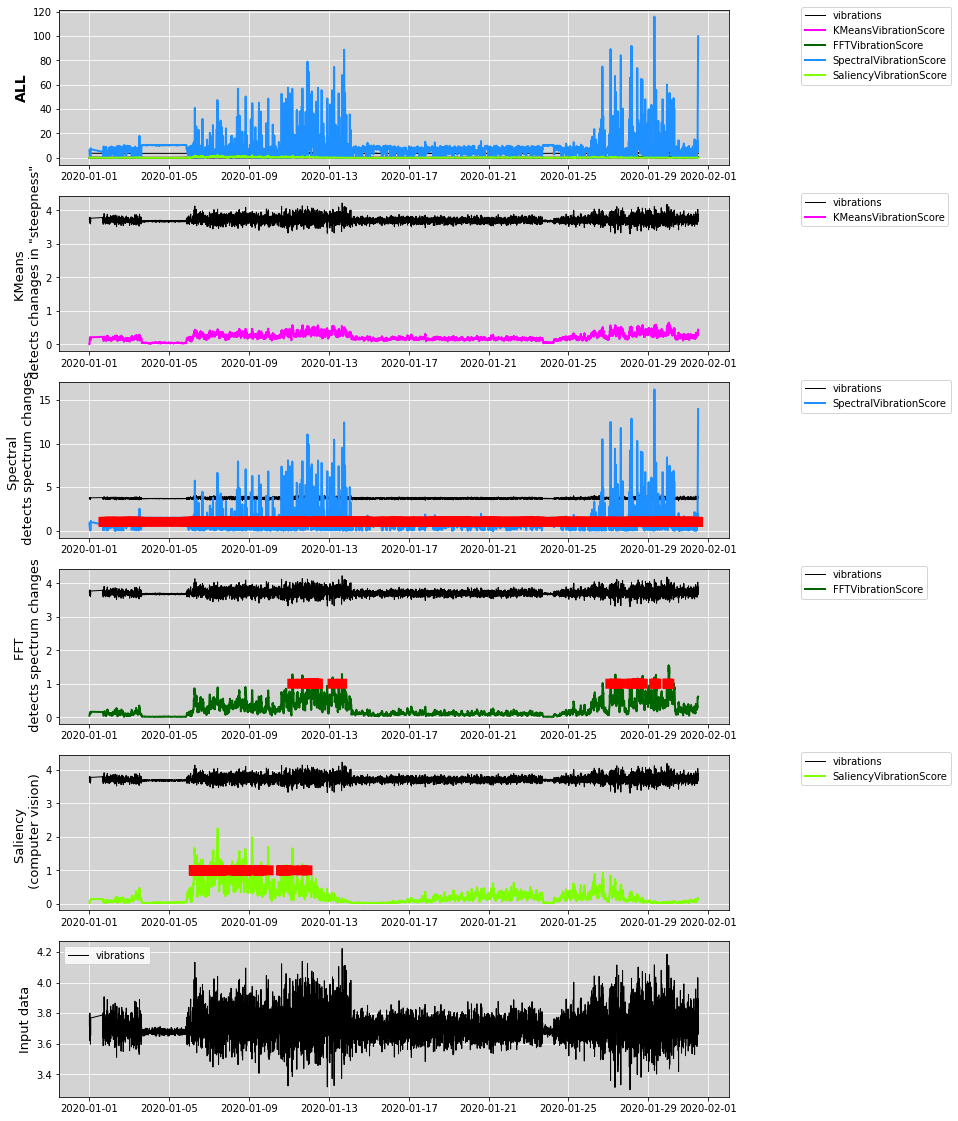

In [72]:
#df_inputb2[spectral].values[df_inputb2[spectral] > 0.001] = 0.001
df_inputb2[fft].values[df_inputb2[fft] < -1] = -1
df_inputb2[kmeansA] = df_inputb2[kmeans]
df_inputb2[kmeansA].values[df_inputb2[kmeansA] < kmeans_break] = np.nan
df_inputb2[kmeansA].values[df_inputb2[kmeansA] > kmeans_break] = kmeans_break
df_inputb2[kmeansB] = df_inputb2[kmeans]
df_inputb2[kmeansB].values[df_inputb2[kmeansB] >= kmeans_break] = 4
df_inputb2[kmeansB].values[df_inputb2[kmeansB] < kmeans_break] = 3



df_inputb2[fftA] = df_inputb2[fft]
df_inputb2[fftA].values[df_inputb2[fftA] < fft_break] = np.nan
df_inputb2[fftA].values[df_inputb2[fftA] > fft_break] = fft_break
df_inputb2[spectralA] = df_inputb2[spectral]
df_inputb2[spectralA].values[df_inputb2[spectralA] < 20] = np.nan
df_inputb2[spectralA].values[df_inputb2[spectralA] > 20] = 20
df_inputb2[salA] = df_inputb2[sal]
df_inputb2[salA].values[df_inputb2[salA] < sal_break] = np.nan
df_inputb2[salA].values[df_inputb2[salA] > sal_break] = sal_break
#df_input2[genA] = df_input2[gen]
#df_input2[genA].values[df_input2[genA] < gen_break] = np.nan
#df_input2[genA].values[df_input2[genA] > gen_break] = gen_break

plots = 6

fig, ax = plt.subplots(plots, 1, figsize=(12,20))
cnt=0
ax[cnt].plot(df_inputb2.index, df_inputb2[Temperature],linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_inputb2.index, df_inputb2[kmeans], linewidth=2, color='magenta',label=kmeans)
ax[cnt].plot(df_inputb2.index, df_inputb2[fft]/fft_break, linewidth=2,color='darkgreen',label=fft)
ax[cnt].plot(df_inputb2.index, df_inputb2[spectral]/spectral_break, linewidth=2,color='dodgerblue', label=spectral)
ax[cnt].plot(df_inputb2.index, df_inputb2[sal]/sal_break, linewidth=2,color='chartreuse',label=sal)
#ax[cnt].plot(df_input2.index, df_input2[gen]/gen_break, linewidth=2,color='darkviolet',label=gen)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('ALL',fontsize=14,weight="bold")
cnt=1
ax[cnt].plot(df_inputb2.index, df_inputb2[Temperature],linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_inputb2.index, df_inputb2[kmeans], linewidth=2, color='magenta',label=kmeans)
ax[cnt].plot(df_inputb2.index, df_inputb2[kmeansA], linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('KMeans \n detects chanages in "steepness"',fontsize=13)
cnt=2
ax[cnt].plot(df_inputb2.index, df_inputb2[Temperature],linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_inputb2.index, df_inputb2[spectral]/20, linewidth=2,color='dodgerblue', label=spectral)
ax[cnt].plot(df_inputb2.index, df_inputb2[spectralA]/20, linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('Spectral \n detects spectrum changes', fontsize=13)
cnt=3
ax[cnt].plot(df_inputb2.index, df_inputb2[Temperature],linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_inputb2.index, df_inputb2[fft]/fft_break, linewidth=2,color='darkgreen',label=fft)
ax[cnt].plot(df_inputb2.index, df_inputb2[fftA]/fft_break, linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('FFT \n detects spectrum changes', fontsize=13)
cnt=4
ax[cnt].plot(df_inputb2.index, df_inputb2[Temperature],linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_inputb2.index, df_inputb2[sal]/sal_break, linewidth=2,color='chartreuse', label=sal)
ax[cnt].plot(df_inputb2.index, df_inputb2[salA]/sal_break, linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('Saliency \n (computer vision)', fontsize=13)
cnt=5
ax[cnt].plot(df_inputb2.index, df_inputb2[Temperature],linewidth=1,color='black',label=Temperature)
#ax[cnt].plot(df_inputb2.index, df_inputb2[gen]/gen_break, linewidth=2,color='darkviolet', label=gen)
#ax[cnt].plot(df_inputb2.index, df_inputb2[genA]/gen_break, linewidth=10, color='red')
ax[cnt].legend()#bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('Input data', fontsize=13)

for i in range(plots):
    ax[i].grid(True, color='white')
    ax[i].set_facecolor('lightgrey')


#ax.set_ylabel('Temperature-50')

2020-06-02T14:12:36.344 WARNING matplotlib.legend._parse_legend_args No handles with labels found to put in legend.


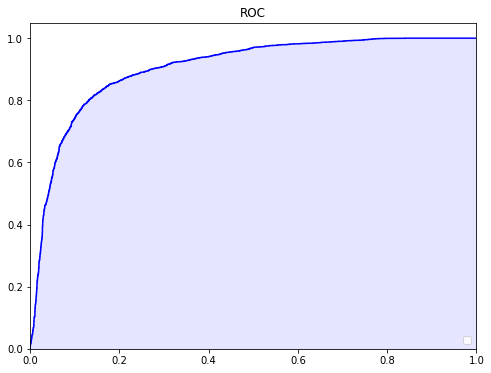

In [82]:
# ROC curve FFT
from sklearn.metrics import roc_curve, auc, roc_auc_score

# before anomaly "negatives"
before_anomaly1 = dt.datetime(2020,1,7,0,0,0)  # before anomaly "negatives"
after_anomaly1 = dt.datetime(2020,1,14,0,0,0)  
before_anomaly2 = dt.datetime(2020,1,27,0,0,0) 
after_anomaly2 = dt.datetime(2020,1,31,0,0,0)

df_inputb2.loc[df_inputb2.index < before_anomaly1,'actual'] = 0
df_inputb2.loc[(df_inputb2.index > before_anomaly1) &
           (df_inputb2.index < after_anomaly1),'actual'] = 1
df_inputb2.loc[(df_inputb2.index > after_anomaly1) &
           (df_inputb2.index < before_anomaly2),'actual'] = 0
df_inputb2.loc[(df_inputb2.index > before_anomaly2) &
           (df_inputb2.index < after_anomaly2),'actual'] = 1
df_inputb2.loc[(df_inputb2.index > after_anomaly2),'actual'] = 0


yyy_test = df_inputb2['actual'].values

np_range = np.arange(0, 151, 1)
score_list = []
fpr_list = []
tpr_list = []
roc_auc_list = []
for ths in np_range:
    yyy_score_ = (np.greater(df_inputb2[fft], ths) | np.greater(df_inputb2[sal], ths)).astype(int)
    score_list.append(yyy_score_)
    fpr_, tpr_, _ = roc_curve(yyy_test, yyy_score_)
    fpr_list.append(fpr_)
    tpr_list.append(tpr_)
    roc_auc_list.append(auc(fpr_,tpr_))

    
yy_score = np.asarray(score_list)
fpr = np.asarray(fpr_list)
tpr = np.asarray(tpr_list)
roc_auc = np.asarray(roc_auc_list)

yyF_score = np.maximum(df_inputb2[fft].values, df_inputb2[sal].values)
fprF, tprF, _ = roc_curve(yyy_test, yyF_score/200)
roc_aucF = auc(fprF, tprF)


fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(fprF, tprF, color='blue', lw=1.5)
ax.fill_between(fprF, tprF, y2=0, color='blue', alpha=0.1)
#ax.plot(fpr[20], tpr[20], color='red',lw=1, label='ROC curve 20 (area = %0.2f)' % roc_auc[20])
#ax.plot(fpr[30], tpr[30], color='turquoise',lw=1, label='ROC curve 30 (area = %0.2f)' % roc_auc[30])
#ax.plot(fpr[50], tpr[50], color='orange',lw=1, label='ROC curve 50 (area = %0.2f)' % roc_auc[50])
#ax.plot(fpr[75], tpr[75], color='violet',lw=1, label='ROC curve 75 (area = %0.2f)' % roc_auc[75])
#ax.plot(fpr[100], tpr[100], color='green',lw=1, label='ROC curve 100 (area = %0.2f)' % roc_auc[100])
#ax.plot(fpr[150], tpr[150], color='red',lw=1, label='ROC curve 150 (area = %0.2f)' % roc_auc[150])
#ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
#plt.xlabel('False Positive Rate - lower is better, higher means false alerts')
#plt.ylabel('True Positive Rate - higher is better, we detect more anomalies')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()
